In [1]:
#%load_ext autoreload
#%autoreload 2

In [47]:
import pyro
from pyro.optim import Adam, ClippedAdam
from pyro.infer import TraceMeanField_ELBO, TraceEnum_ELBO, TraceGraph_ELBO, Trace_ELBO

import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [73]:
data = pd.read_csv("/Users/lucreziavaleriani/Desktop/orfeo_LTS/CNA/segmentation/res_nanopore/data/smooth_data_meth.tsv",
                   sep = '\t') 
data  = data[data['CN'].isin(['1:1', '2:1', '2:2', '2:0', '1:0'])]
data['median_baf'] = data['median_baf'].apply(lambda x: 1 - x if x > 0.5 else x)
data['pos'] = range(1, len(data) + 1)

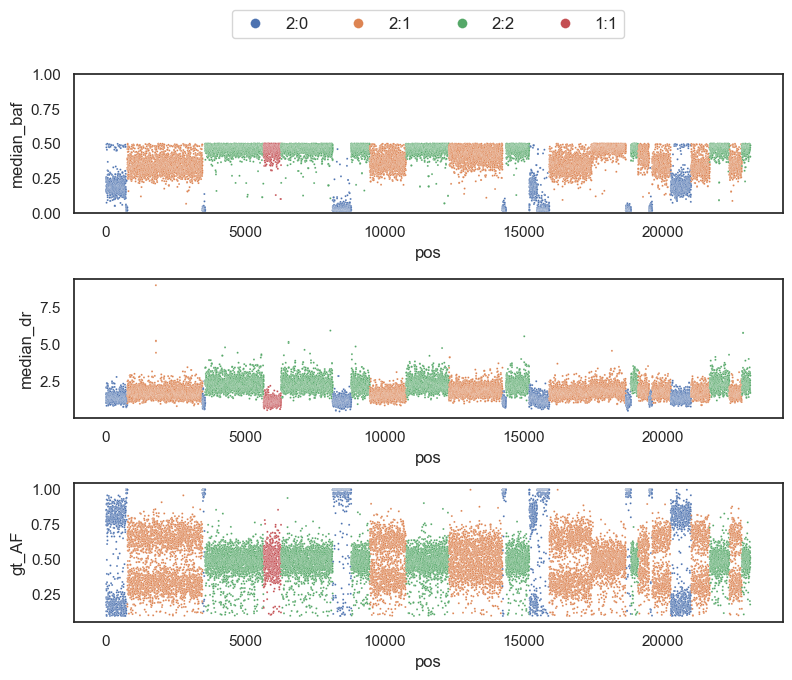

In [74]:
sns.set_theme(style="white", font_scale=1)
fig, axes = plt.subplots(3, 1, figsize=(8, 7))

baf = sns.scatterplot(data=data, x="pos", y="median_baf", s=2, ax=axes[0], hue="CN")
dr = sns.scatterplot(data=data, x="pos", y="median_dr", s=2, ax=axes[1], hue="CN", legend=False)
vaf = sns.scatterplot(data=data, x="pos", y="gt_AF", s=2, ax=axes[2], hue="CN", legend=False)

axes[0].set_ylim(0,1) 
sns.move_legend(
    baf, 
    "lower center",
    bbox_to_anchor=(.5, 1.2), ncol=4, title=None, frameon=True,
    prop={'size': 12},
    markerscale=5 
)

fig.tight_layout()

In [75]:
data_input = {'baf':torch.tensor(np.array(data.mean_baf).reshape(-1, 1)), 
            'dr':torch.tensor(np.array(data.mean_dr).reshape(-1, 1)),
            'vaf':torch.tensor(np.array(data.gt_AD).reshape(-1, 1)),
            'dp':torch.tensor(np.array(data.gt_DP).reshape(-1, 1)),
            'dp_snp':torch.tensor(np.array(data.gt_DP).reshape(-1, 1))}

In [76]:
import locate.locate as l
from locate.models import Clonal
from locate.utils import plot_loss
from locate.utils import plot_results_simulations

In [77]:
locate = l.LOCATE(CUDA = False)

locate.set_model(Clonal)
locate.set_optimizer(ClippedAdam)
locate.set_loss(TraceEnum_ELBO)
locate.initialize_model({"baf": data_input["baf"],
                         "dr": data_input["dr"], 
                         "dp_snp": data_input["dp_snp"], 
                         "vaf": data_input["vaf"], 
                         "dp": data_input["dp"]
                         })

locate.set_model_params({"jumping_prob" : 1e-6,
                         "fix_purity": False,
                         "prior_purity": 0,
                         "prior_ploidy": 2,
                         "scaling_factors": [1,1,1]})

In [78]:
ll = locate.run(steps = 500, param_optimizer = {"lr" : 0.05})

/Users/lucreziavaleriani/opt/anaconda3/envs/locate/lib/python3.11/site-packages/pyro/infer/traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(
ELBO: 361075.859855576  : 100%|██████████| 500/500 [00:24<00:00, 20.62it/s]


Done!


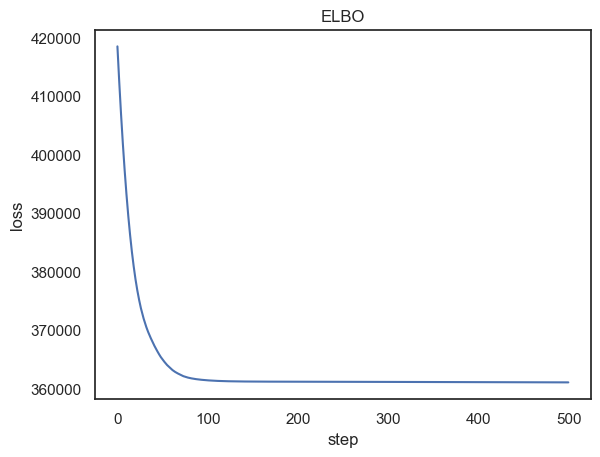

In [79]:
plot_loss(ll[0])

In [80]:
params = locate.learned_parameters_Clonal()

In [81]:
params['purity']

array(0.99997663, dtype=float32)

In [82]:
res = pd.DataFrame({'CN_Major':params["CN_Major"]+0.05,
                    'CN_minor':params["CN_minor"]-0.05,
                    'pos':[i for i in range(len(params["CN_minor"]))]})

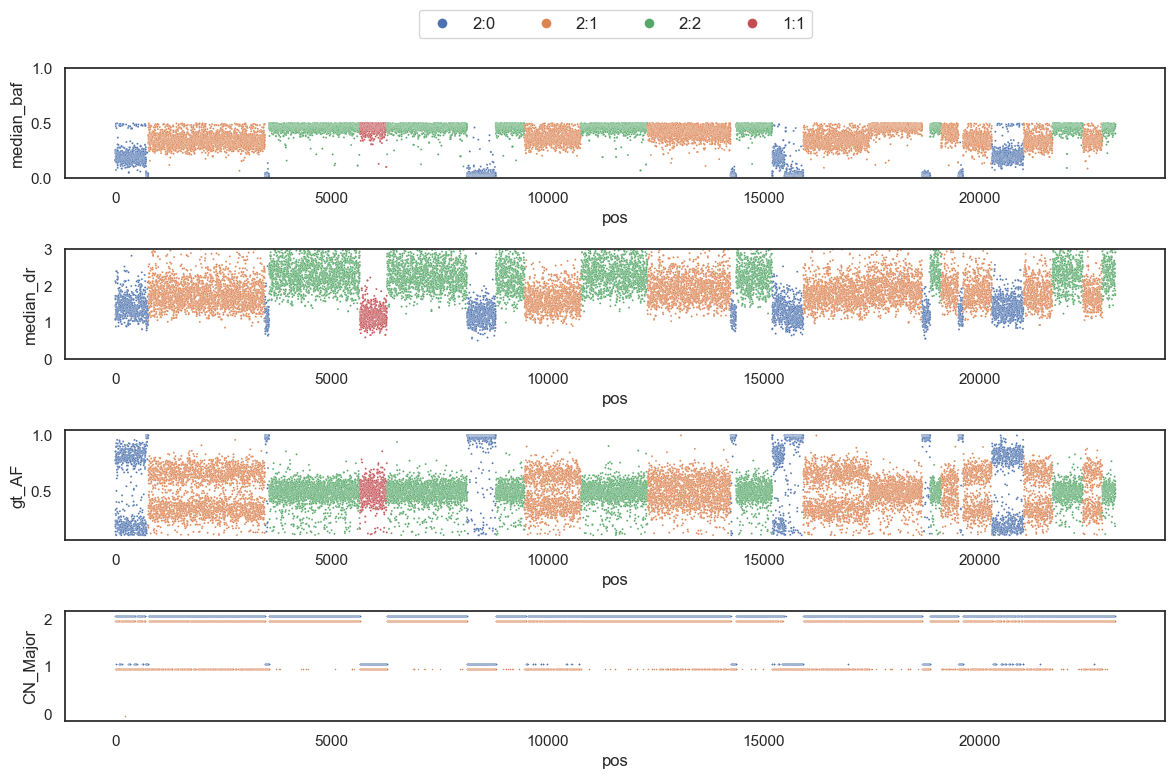

In [86]:
sns.set_theme(style="white", font_scale=1)
fig, axes = plt.subplots(4, 1, figsize=(12, 8))

baf = sns.scatterplot(data=data, x="pos", y="median_baf", s=2, ax=axes[0], hue="CN")
dr = sns.scatterplot(data=data, x="pos", y="median_dr", s=2, ax=axes[1], hue="CN", legend=False)
vaf = sns.scatterplot(data=data, x="pos", y="gt_AF", s=2, ax=axes[2], hue="CN", legend=False)

cn = sns.scatterplot(data=res, x="pos", y="CN_Major", s=1, ax=axes[3], legend=False)
cn = sns.scatterplot(data=res, x="pos", y="CN_minor", s=1, ax=axes[3], legend=False)

axes[0].set_ylim(0,1) 
axes[1].set_ylim(0,3) 
sns.move_legend(
    baf, 
    "lower center",
    bbox_to_anchor=(.5, 1.2), ncol=4, title=None, frameon=True,
    prop={'size': 12},
    markerscale=5 
)

fig.tight_layout()